# SYDE 552 Assignment 2: Vision
### Due Monday, February 19, 11:59pm
### Value: 15% of total marks for the course

This assignment covers the mammilian vision system, including both questions about the biology itself and constructing computational models based on Regression and Convolutional Neural Networks.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Vision System

The purpose of this part of the assignment is to test your knowledge of the brain’s visual system and the relationship between neurobiological features and computational properties. The best answers will discuss both function and anatomy, and will draw on specific anatomical examples to support theoretical claims. You are encouraged to discuss answers with your classmates, consult the slides notes, or use external resources -- but your answers must be your own! In particular, read the Kandel et al. chapters listed on the slides. Expect to write around 5 sentences for each 1 point.

**1.a) [2 marks]** The neurons in different parts of the brain are sensitive to different things, and can be thought of as different feature detectors.  For each of the types of neurons listed below, describe what feature they detect, their receptive fields, and how their connectivity to other neurons and/or their internal neural processes helps them to do this feature detection:
- Cones
- Sustained Ganglion Cells
- Transient Ganglion Cells
- Simple Cells

**1. b) [1 marks]** Describe two instances where retinotopic organization facilitates visual processing.  For each example, be sure to mention its anatomical location and discuss how retinitopy contributes to the feature detection.

**1. c) [2 marks]** Discuss the similarities and differences between convolutional neural networks and the visual system.

# 2. Classifying Stimuli Using Regression

The retina transforms the light entering an eye into a particular set of features, which are then sent to the rest of the brain for further processing.  In this section we look at how neurons might detect patterns, and how that detection changes with different feature detectors.

The data we will use for this is the classic MNIST dataset 

In [42]:
import torchvision
mnist = torchvision.datasets.MNIST(root='.', download=True)

The MNIST digits are 28x28 pixels each, each pixel is a value from 0 to 255, and there are 60,000 of them.  The raw data is in `mnist.data` and the target value (i.e. the actual digit) is in `mnist.targets`.  Here are the first 24 of each:

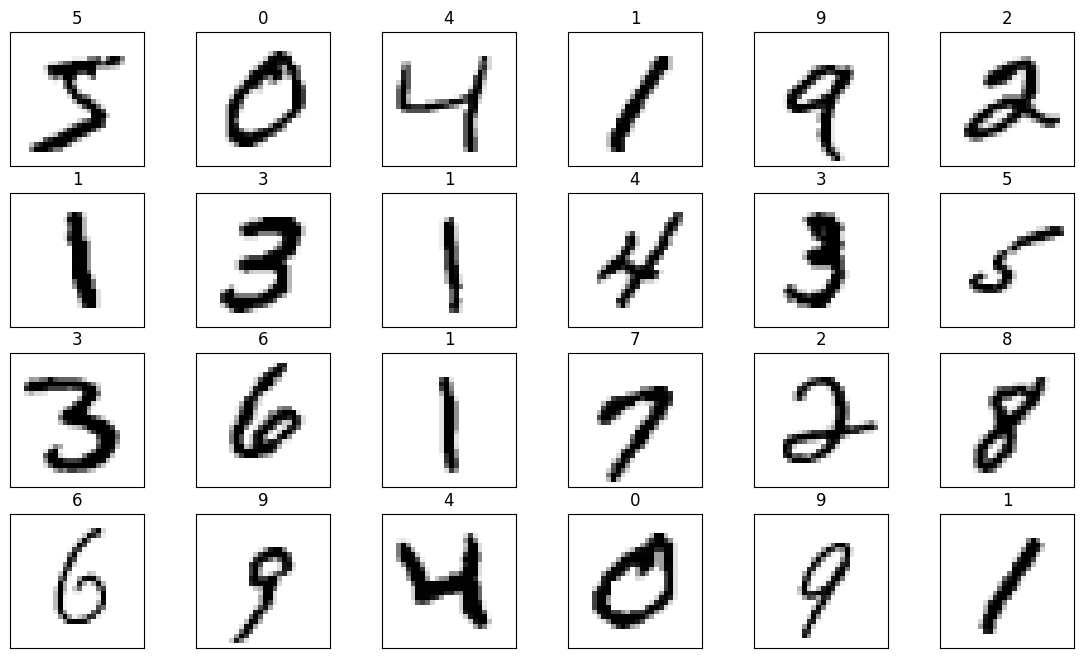

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(mnist.data[i], vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))

**2.a) [1 mark]** We can imagine the MNIST digits as 784 (28 times 28) input neurons.  We want to connect these 784 neurons to 10 output neurons, one for each digit, and see how accurately we can classify the digits.  

To find the weights in this question, we will use Ridge Regression.  `X` is the MNIST input data, divided by 255 to rescale it to between 0 and 1, and then reshaped to be a 60000x784 matrix

```
X = mnist.data.reshape((60000,28*28)).float()/255
```

The target data T is a "one-hot" representation of our outputs.  That is, instead of the desired output to be `5`, the output should be `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]` and if the desired output should be `0`, that would be `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.  

```
T = torch.nn.functional.one_hot(mnist.targets).float()
```

If our output is `Y=X @ W`, we need to find `W` such that `Y` is as close as possible to `T`.  For Ridge Regression, this is computed as

```
W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T)
```

where `I` is an identity matrix of the correct size (`torch.eye(784).float()`) and `lambd` is the $\lambda$ parameter that stops the regression from overfitting.

When building any sort of classifier model, we generally want to create the model using one set of data, and then test it on another set of data.  Here, we will use the first 5,000 data points for creating ("training") the model, and the other 55,000 for testing:

```
N = 5000
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing
```

Given this data, you should find `W` using *only* the `X_train` and `T_train` data.  Once you find `W` you can apply it to the `X_train` and `X_test` to get `Y_train` and `Y_test`

```
Y_train = X_train @ W
Y_test = X_test @ W
```

Finally, you can compute the accuracy by determining when the output is the correct category.  Here we will do this by counting when the largest output value in each row in `Y` is at the same spot as the largest output value in each row in `T`:

```
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
```

- Compute the training and testing accuracy when $\lambda=1$ and we use the first 5,000 data points as for training (and test on the remaining 55,000).  Report both numbers.  
- Do we expect the testing accuracy to be larger or smaller than the training accuracy?  Why?


In [44]:
import torch
import torchvision
from torch.nn.functional import one_hot

# Download MNIST dataset
mnist = torchvision.datasets.MNIST(root='.', download=True)

# Reshape and normalize the input data
X = mnist.data.reshape((60000, 28*28)).float() / 255

# One-hot encode the target data
T = one_hot(mnist.targets).float()

# Split data into training and testing sets
N = 5000
X_train, X_test = X[:N], X[N:]
T_train, T_test = T[:N], T[N:]

# Ridge Regression parameters
lambd = 1.0
I = torch.eye(28*28).float()

# Finding W using training data
W = torch.inverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train)

# Applying W to training and testing data
Y_train = X_train @ W
Y_test = X_test @ W

# Computing accuracies
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1) == torch.argmax(T_train, axis=1)) / len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1) == torch.argmax(T_test, axis=1)) / len(Y_test)

# Reporting accuracies
print(f"Training Accuracy: {accuracy_train.item()}")
print(f"Testing Accuracy: {accuracy_test.item()}")

Training Accuracy: 0.9034000039100647
Testing Accuracy: 0.8191817998886108


We expect the testing accuracy to be less than the training accuracy, as the weight matrix was trained on the training data and thus will be less accurate for unseen data.

**2. b) [2 marks]**  Repeat part a) but vary the value of `lambd` from $10^{-5}$ to $10^5$.   You can use a `for` loop such as `for lambd in np.logspace(-5, 5, 11):`.  

- Generate a single plot that shows the training and testing accuracy.  Make sure to label your axes and the lines on the plot.  

- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy).  
- Why does changing `lambd` affect the accuracy?  
- Why would having a large `lambd` value be good for making a biologically realistic model?

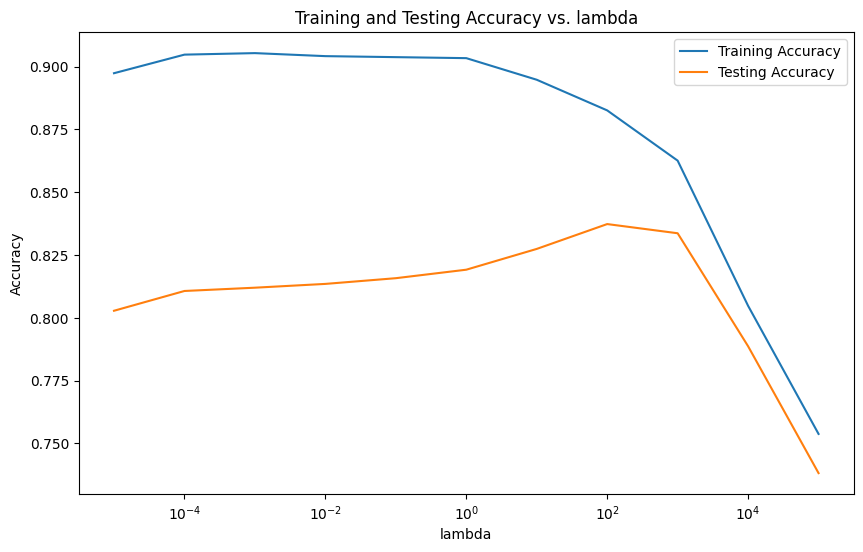

The best value for lambda is: 0.001


In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Vary lambd values
lambd_values = np.logspace(-5, 5, 11)

# Initialize lists to store accuracies
training_accuracies_b = []
testing_accuracies = []

# Ridge Regression and accuracy calculation for each lambd
for lambd in lambd_values:
    # Ridge Regression parameters
    I = torch.eye(28*28).float()

    # Finding W using training data
    W = torch.inverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train)

    # Applying W to training and testing data
    Y_train = X_train @ W
    Y_test = X_test @ W

    # Computing accuracies
    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1) == torch.argmax(T_train, axis=1)) / len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1) == torch.argmax(T_test, axis=1)) / len(Y_test)

    # Append accuracies to lists
    training_accuracies_b.append(accuracy_train.item())
    testing_accuracies.append(accuracy_test.item())

# Generate a single plot
plt.figure(figsize=(10, 6))
plt.semilogx(lambd_values, training_accuracies_b, label='Training Accuracy')
plt.semilogx(lambd_values, testing_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy vs. lambda')
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find the best value for lambda
best_lambd = lambd_values[np.argmax(training_accuracies_b)]
print(f"The best value for lambda is: {best_lambd}")

- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy).  

The lambda that gives the best training accuracy is 0.001.

- Why does changing `lambd` affect the accuracy?  

Changing lambda affects accuracy because it controls the regularization strength. Higher lambda values lead to stronger regularization, preventing overfitting by penalizing large weights.

- Why would having a large `lambd` value be good for making a biologically realistic model?

🤔 Having a large lambda value is good for a biologically realistic model because it helps prevent overfitting and makes the model more robust to variations in the input data. This is important for generalization, which is a desirable characteristic in biologically inspired models.

**2. c) [1 mark]** The input we have used so far is not very realistic.  In real life, when we see written digits, they are under a wide range of lighting conditions. For this question, we change `X` by scaling it randomly and adding a random background brightness.

```
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000)[:,None]) + torch.rand(60000)[:,None]
```

To see what this looks like, here is how you can plot it:

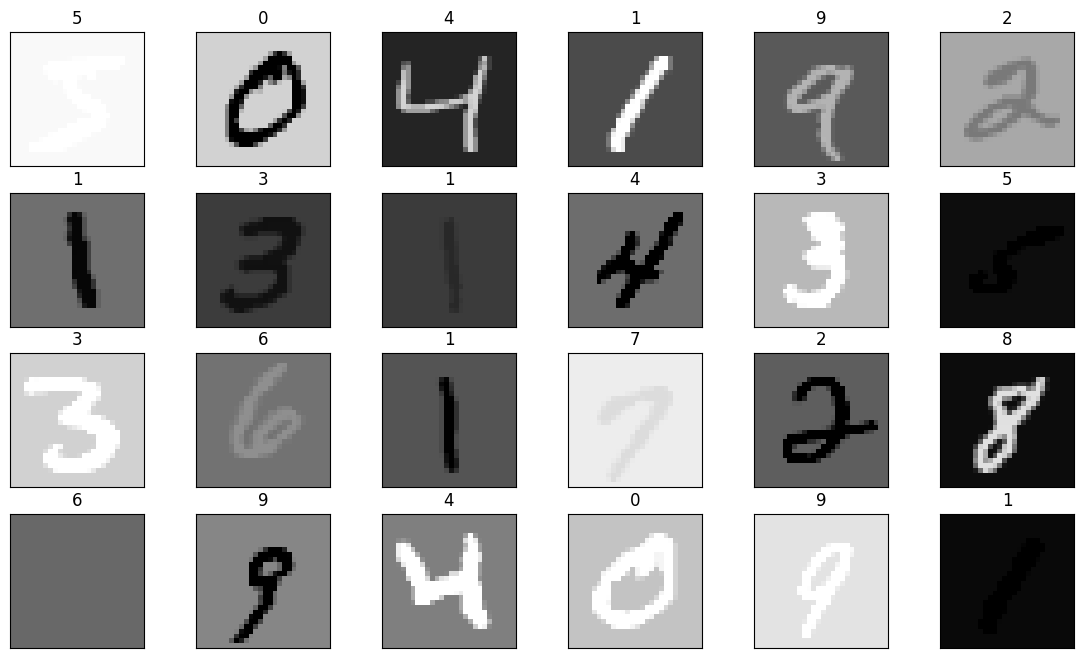

In [46]:
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(X[i].reshape(28,28), vmin=0, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))


- Generate the same plot as in 2b) but for this new dataset.  
- Is this a harder or easier task than with the original dataset?
- Is this new dataset more like the data at the retina or like the data in the ganglion cells?
- Is the original dataset more like the data at the retina or like the data in the ganglion cells?

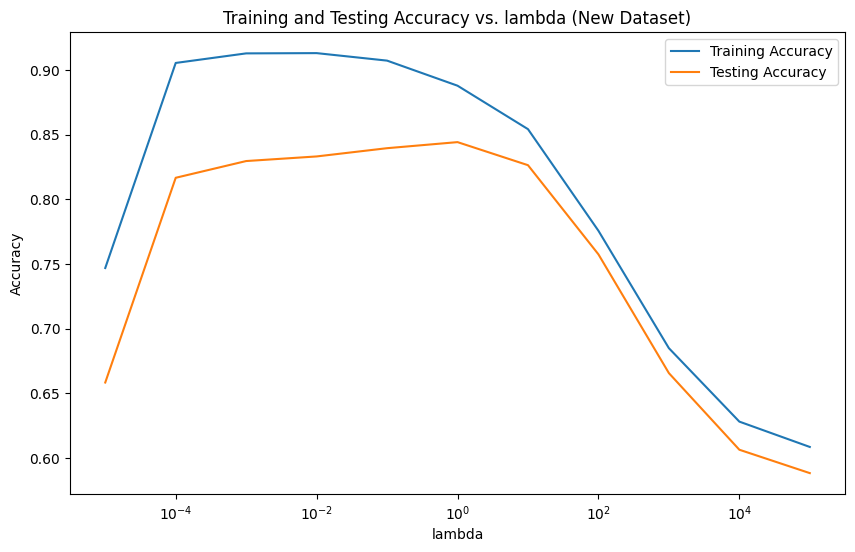

Original dataset max accuracy: 0.9053999781608582
New dataset max accuracy: 0.9129999876022339
The new dataset is an easier task than the original dataset.


In [53]:
T = one_hot(mnist.targets).float()

N = 5000
X_train, X_test = X[:N], X[N:]
T_train, T_test = T[:N], T[N:]

lambd_values = np.logspace(-5, 5, 11)

training_accuracies_c = []
testing_accuracies = []

for lambd in lambd_values:
    I = torch.eye(28*28).float()
    W = torch.inverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train)

    Y_train = X_train @ W
    Y_test = X_test @ W

    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1) == torch.argmax(T_train, axis=1)) / len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1) == torch.argmax(T_test, axis=1)) / len(Y_test)

    training_accuracies_c.append(accuracy_train.item())
    testing_accuracies.append(accuracy_test.item())

plt.figure(figsize=(10, 6))
plt.semilogx(lambd_values, training_accuracies_c, label='Training Accuracy')
plt.semilogx(lambd_values, testing_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy vs. lambda (New Dataset)')
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

original_accuracy_train = max(training_accuracies_b)
new_accuracy_train = max(training_accuracies_c)
print(f"Original dataset max accuracy: {original_accuracy_train}")
print(f"New dataset max accuracy: {new_accuracy_train}")

if new_accuracy_train > original_accuracy_train:
    print("The new dataset is an easier task than the original dataset.")
else:
    print("The new dataset is a harder task than the original dataset.")

🤔 Aren't the ganglion cells in the retina??

**2. d) [1 mark]** We can think of neurons in the visual system as transforming the data in various ways.  Given the dataset in 2c), neurons might be able to transform it to look more like the origin data.

Here are three data transformations that could be applied here:

Subtracting the Mean
```
X = X-torch.mean(X, axis=1)[:,None]
```

Absolute value
```
X = torch.abs(X)
```

Normalizing
```
X = X/torch.linalg.norm(X, axis=1)[:,None]
```

- Apply all three of them (in the order shown above) to the dataset and generate the same graph as in 2b) and 2c).
- How does the performance of the network compare to that of 2b) and 2c)?
- Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?
- Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?

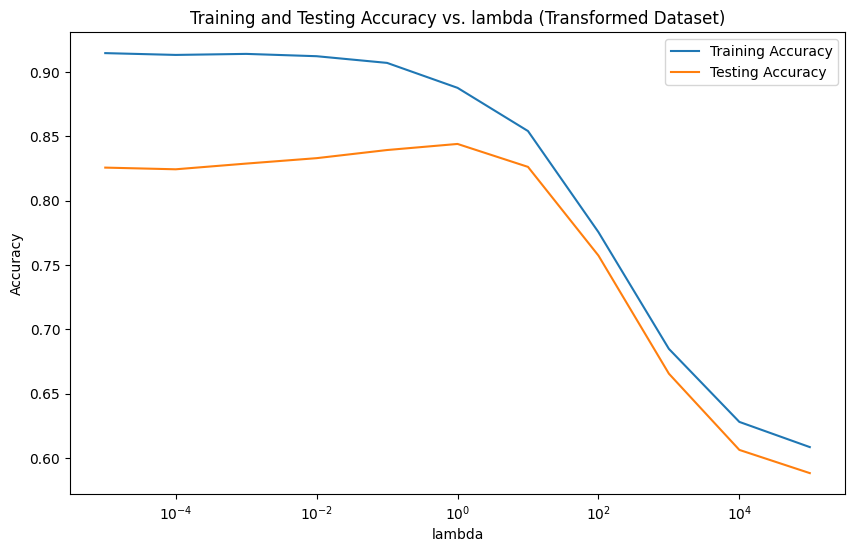

Original dataset max accuracy: 0.9053999781608582
New dataset max accuracy: 0.4212000072002411
Transformed dataset max accuracy: 0.9147999882698059


In [48]:
X = X-torch.mean(X, axis=1)[:,None]
X = torch.abs(X)
X = X/torch.linalg.norm(X, axis=1)[:,None]

T = one_hot(mnist.targets).float()

N = 5000
X_train, X_test = X[:N], X[N:]
T_train, T_test = T[:N], T[N:]

lambd_values = np.logspace(-5, 5, 11)

training_accuracies_d = []
testing_accuracies = []

for lambd in lambd_values:
    I = torch.eye(28*28).float()
    W = torch.pinverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train)

    Y_train = X_train @ W
    Y_test = X_test @ W

    accuracy_train = torch.sum(torch.argmax(Y_train, axis=1) == torch.argmax(T_train, axis=1)) / len(Y_train)
    accuracy_test = torch.sum(torch.argmax(Y_test, axis=1) == torch.argmax(T_test, axis=1)) / len(Y_test)

    training_accuracies_d.append(accuracy_train.item())
    testing_accuracies.append(accuracy_test.item())

plt.figure(figsize=(10, 6))
plt.semilogx(lambd_values, training_accuracies_d, label='Training Accuracy')
plt.semilogx(lambd_values, testing_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy vs. lambda (Transformed Dataset)')
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

original_accuracy_train = max(training_accuracies_b)
new_accuracy_train = max(training_accuracies_c)
transformed_accuracy_train = max(training_accuracies_d)

print(f"Original dataset max accuracy: {original_accuracy_train}")
print(f"New dataset max accuracy: {new_accuracy_train}")
print(f"Transformed dataset max accuracy: {transformed_accuracy_train}")

# 3. Classifying Stimuli Using Backpropogation

Regression is restricted to learning the layer of weights that produces the final output.  If we want to also learn what features are most useful for producing that output, we need a more complex learning rule, and this is typically backpropogation.  Here we will classify the same data as in question 2, and we will build up different network structures to do so.

Backpropogation tends to work best when learning on a bunch of data at the same time (a "batch").  The following code will set up the same training and testing data as in question 2, but presented in randomized batches of 1000 at a time.

```python
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)
```

To create a neural network, we need to define what the weights are we will learn and we need to define the computation that the network will perform.  Here is the definition of a simple network that has an input of 784 values (the MNIST inputs), which go to 50 "hidden"-layer neurons, and then to the output 10 neurons.  So the network will learn to transform the 784 inputs into 50 new representations, and from those 50 features it will learn weights to create an output of 10 values (our 10 categories).  This is known as a multi-layer perceptron, or a standard neural network with a single hidden layer.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()
```

Finally, we need to train our model.  When training, it is useful to keep track of how well the model is doing on the testing data.  Since testing the network takes time, we don't necessarily want to do it all the time.  Instead, the following code trains the network 10 times, and then records how well the network does on the training data and on the testing data.

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  

mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()

# create the learning rule
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,   # learning rate
                      momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)
    
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)


Given the above code, you can train your network 10 times by doing

```python
for i in range(10):
    continue_training()
```

If you want to continue training even more, you can just run that `for` loop again.

To plot the final accuracy results, you can use

```python
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()
```

**3. a) [1 mark]** Run the model above for 10 iterations (i.e. call `continue_training` 10 times).

- Plot the training and testing accuracy.  
- Is this model better or worse than the best models developed in question 2?

In [66]:
for i in range(10):
    continue_training()

/var/folders/zz/c5vwdr1x3sd7k7qfw66pt9240000gn/T/ipykernel_60922/894367666.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 Training accuracy: 0.8604000210762024
Iteration 1 Testing accuracy: 0.854200005531311
Iteration 2 Training accuracy: 0.901199996471405
Iteration 2 Testing accuracy: 0.8853999972343445
Iteration 3 Training accuracy: 0.9154000282287598
Iteration 3 Testing accuracy: 0.8953999876976013
Iteration 4 Training accuracy: 0.9247999787330627
Iteration 4 Testing accuracy: 0.9010000228881836
Iteration 5 Training accuracy: 0.9326000213623047
Iteration 5 Testing accuracy: 0.9038000106811523
Iteration 6 Training accuracy: 0.9386000037193298
Iteration 6 Testing accuracy: 0.9070000052452087
Iteration 7 Training accuracy: 0.9422000050544739
Iteration 7 Testing accuracy: 0.9074000120162964
Iteration 8 Training accuracy: 0.9462000131607056
Iteration 8 Testing accuracy: 0.9089999794960022
Iteration 9 Training accuracy: 0.9498000144958496
Iteration 9 Testing accuracy: 0.9107999801635742
Iteration 10 Training accuracy: 0.9539999961853027
Iteration 10 Testing accuracy: 0.9115999937057495


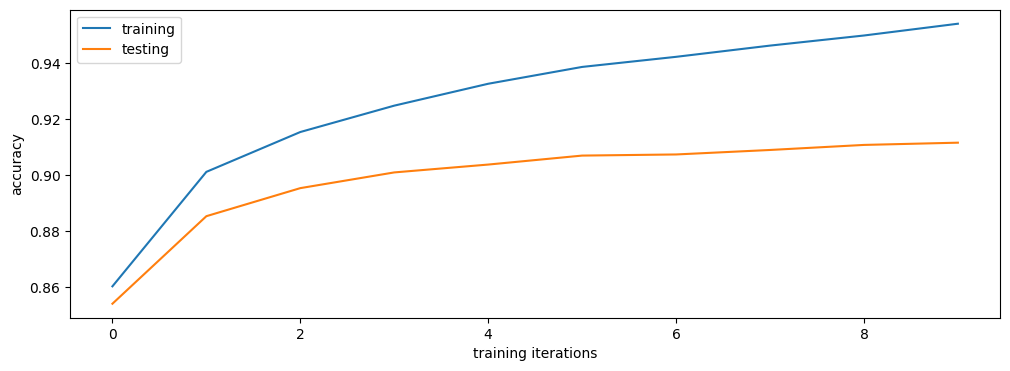

PART 3A), FINAL TESTING ACCURACY: 91.16%


In [70]:
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

print(f"PART 3A), FINAL TESTING ACCURACY: {np.round(accuracy_test[-1] * 100, 2)}%")

**3. b) [1 mark]** Repeat question 3a five times.  This does not mean to run a single model for 50 iterations.  Rather, you need to reset the model and train it again.  The easiest way to do this is to recreate the network and the optimizer like this:

```python
network = Net()
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,
                      momentum=0.5)
```

- Make a plot showing the 5 different training accuracies and 5 different testing accuracies
- Also show the average training and testing accuracy on the plot.
- Each of the 5 models should show slightly different accuracies.  Why is this the case?


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  
import torchvision
import numpy as np
import matplotlib.pyplot as plt

mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
# Initialize variables to store accuracies for each run
all_accuracy_train = []
all_accuracy_test = []

# Repeat the training process 5 times
for _ in range(5):
    # Create the network and optimizer
    network = Net()
    optimizer = optim.SGD(network.parameters(), 
                          lr=0.1,
                          momentum=0.5)
    
    # Variables to keep track of the training and testing accuracy for each run
    accuracy_train = []
    accuracy_test = []

    def continue_training():
        network.train()
        for i in range(10):
            correct = 0
            for data, target in train_loader:
                optimizer.zero_grad()
                output = network(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                optimizer.step()
                
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        score = float(correct/len(train_loader.dataset))
        accuracy_train.append(score)
        print('Iteration', len(accuracy_train), 'Training accuracy:', score)

        correct = 0
        network.eval()
        for data, target in test_loader:
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        score = float(correct/len(test_loader.dataset))
        accuracy_test.append(score)
        print('Iteration', len(accuracy_test), 'Testing accuracy:', score)

    # Run the training process
    for i in range(10):
        continue_training()

    # Append the accuracies for each run to the list
    all_accuracy_train.append(accuracy_train)
    all_accuracy_test.append(accuracy_test)


/var/folders/zz/c5vwdr1x3sd7k7qfw66pt9240000gn/T/ipykernel_60922/4011359748.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 Training accuracy: 0.8550000190734863
Iteration 1 Testing accuracy: 0.8492000102996826
Iteration 2 Training accuracy: 0.901199996471405
Iteration 2 Testing accuracy: 0.8866000175476074
Iteration 3 Training accuracy: 0.9150000214576721
Iteration 3 Testing accuracy: 0.8966000080108643
Iteration 4 Training accuracy: 0.9246000051498413
Iteration 4 Testing accuracy: 0.9020000100135803
Iteration 5 Training accuracy: 0.9315999746322632
Iteration 5 Testing accuracy: 0.9052000045776367
Iteration 6 Training accuracy: 0.9387999773025513
Iteration 6 Testing accuracy: 0.9067999720573425
Iteration 7 Training accuracy: 0.9423999786376953
Iteration 7 Testing accuracy: 0.9092000126838684
Iteration 8 Training accuracy: 0.9485999941825867
Iteration 8 Testing accuracy: 0.9101999998092651
Iteration 9 Training accuracy: 0.9520000219345093
Iteration 9 Testing accuracy: 0.9115999937057495
Iteration 10 Training accuracy: 0.9552000164985657
Iteration 10 Testing accuracy: 0.9120000004768372
Iteration

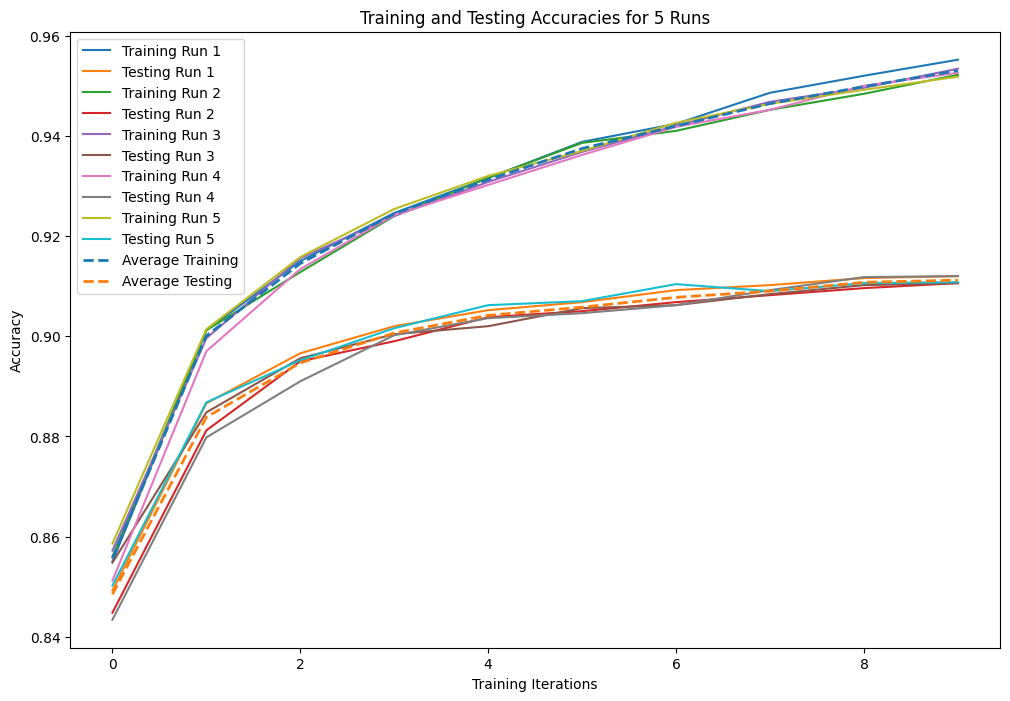

In [57]:
# Plot the training and testing accuracies for each run
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.plot(all_accuracy_train[i], label=f'Training Run {i + 1}')
    plt.plot(all_accuracy_test[i], label=f'Testing Run {i + 1}')

# Calculate and plot the average accuracies
average_accuracy_train = np.mean(all_accuracy_train, axis=0)
average_accuracy_test = np.mean(all_accuracy_test, axis=0)

plt.plot(average_accuracy_train, label='Average Training', linestyle='--', linewidth=2)
plt.plot(average_accuracy_test, label='Average Testing', linestyle='--', linewidth=2)

plt.legend()
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies for 5 Runs')
plt.show()

print(f"PART 3B), FINAL TESTING ACCURACY: {np.round(average_accuracy_test[-1] * 100, 2)}%")

**3. c) [1 mark]** Repeat question 3b varying the number of neurons in the hidden layer of the network.  The current value is 50.  Try it with 5, 10, 20, 50, and 100 neurons.  For each number of neurons, repeat five times and take the average (like in question 3b).  

- Plot the final testing accuracy on the y-axis and the number of neurons on the x-axis.  Note that to speed things up you can remove the testing computation from continue_training until the very end, since we only need the final testing score.


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  
import torchvision
import numpy as np
import matplotlib.pyplot as plt

mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)

class Net(nn.Module):
    def __init__(self, num_neurons):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, num_neurons)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(num_neurons, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
def continue_training(network, optimizer, num_iterations):
    network.train()
    for i in range(num_iterations):
        correct = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    score = float(correct/len(train_loader.dataset))
    return score

# Variables to keep track of the testing accuracy for each number of neurons
neuron_values = [5, 10, 20, 50, 100]
average_accuracy_test = []

# Repeat the training process for different numbers of neurons
for num_neurons in neuron_values:
    # Initialize variables to store testing accuracies for each run
    accuracies_test = []

    # Repeat the training process 5 times for each number of neurons
    for _ in range(5):
        # Create the network and optimizer
        network = Net(num_neurons)
        optimizer = optim.SGD(network.parameters(), 
                              lr=0.1,
                              momentum=0.5)

        # Run the training process and get the training accuracy
        training_accuracy = continue_training(network, optimizer, num_iterations=10)

        # Compute the testing accuracy (only at the end)
        correct = 0
        network.eval()
        for data, target in test_loader:
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        
        # Calculate the testing accuracy and append to the list
        score_test = float(correct/len(test_loader.dataset))
        accuracies_test.append(score_test)

    # Calculate and append the average testing accuracy for this number of neurons
    average_accuracy_test.append(np.mean(accuracies_test))

/var/folders/zz/c5vwdr1x3sd7k7qfw66pt9240000gn/T/ipykernel_60922/3320310926.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


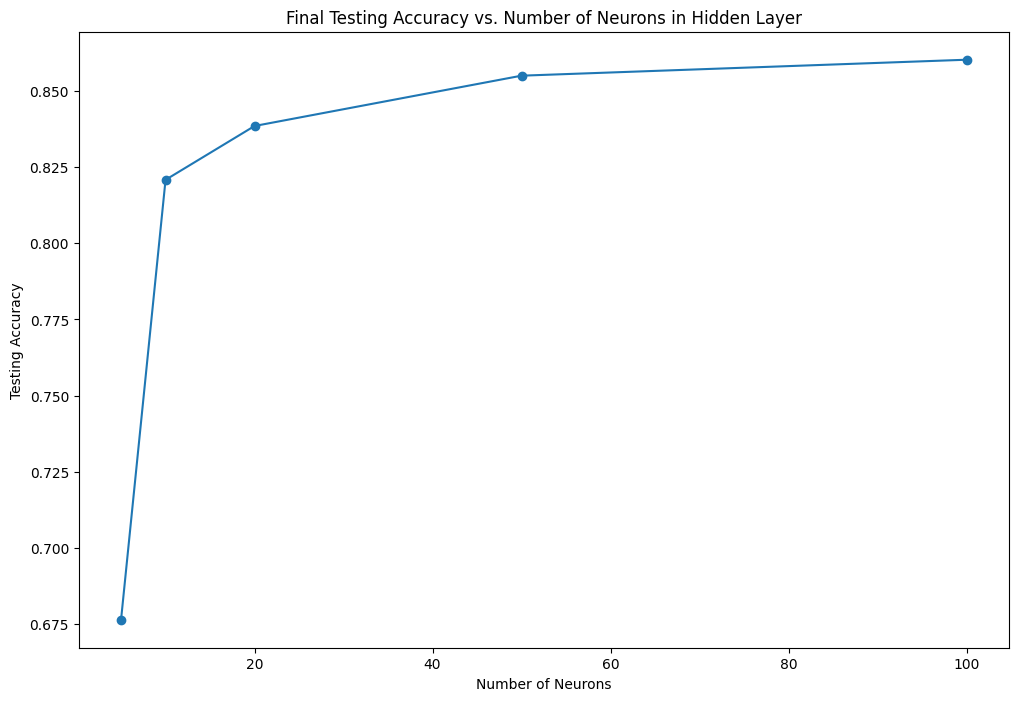

In [59]:
# Plot the final testing accuracy vs. number of neurons
plt.figure(figsize=(12, 8))
plt.plot(neuron_values, average_accuracy_test, marker='o')
plt.title('Final Testing Accuracy vs. Number of Neurons in Hidden Layer')
plt.xlabel('Number of Neurons')
plt.ylabel('Testing Accuracy')
plt.show()

print(f"PART 3C), BEST FINAL TESTING ACCURACY: {np.round(average_accuracy_test[-1] * 100, 2)}%")

**3. d) [2 marks]** Now we will add a convolution layer to our network.  The following network adds two convolution layers before two normal neural network layers.

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
```

The following code can be used to plot the learned features in the first layer:
```python
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()
```

- Train the model through 40 iterations and generate a plot of training and testing accuracy over time.
- Does this perform better or worse than the previous models in this assignment?
- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?
- Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

# Create data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)

# Define the network with convolution layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

# Create the network and optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.5)

# Variables to keep track of training and testing accuracy
accuracy_train = []
accuracy_test = []

# Training process
for i in range(40):
    network.train()
    correct_train = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        pred_train = output.data.max(1, keepdim=True)[1]
        correct_train += pred_train.eq(target.data.view_as(pred_train)).sum()
    
    # Calculate training accuracy and append to the list
    score_train = float(correct_train/len(train_loader.dataset))
    accuracy_train.append(score_train)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score_train)

    # Evaluate the model on the test set
    network.eval()
    correct_test = 0
    for data, target in test_loader:
        output = network(data)
        pred_test = output.data.max(1, keepdim=True)[1]
        correct_test += pred_test.eq(target.data.view_as(pred_test)).sum()

    # Calculate testing accuracy and append to the list
    score_test = float(correct_test/len(test_loader.dataset))
    accuracy_test.append(score_test)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score_test)

/var/folders/zz/c5vwdr1x3sd7k7qfw66pt9240000gn/T/ipykernel_60922/1966666041.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration 1 Training accuracy: 0.1534000039100647
Iteration 1 Testing accuracy: 0.21119999885559082
Iteration 2 Training accuracy: 0.23019999265670776
Iteration 2 Testing accuracy: 0.2565999925136566
Iteration 3 Training accuracy: 0.32440000772476196
Iteration 3 Testing accuracy: 0.3725999891757965
Iteration 4 Training accuracy: 0.4108000099658966
Iteration 4 Testing accuracy: 0.43720000982284546
Iteration 5 Training accuracy: 0.5249999761581421
Iteration 5 Testing accuracy: 0.43779999017715454
Iteration 6 Training accuracy: 0.31839999556541443
Iteration 6 Testing accuracy: 0.33079999685287476
Iteration 7 Training accuracy: 0.3208000063896179
Iteration 7 Testing accuracy: 0.3447999954223633
Iteration 8 Training accuracy: 0.4528000056743622
Iteration 8 Testing accuracy: 0.6582000255584717
Iteration 9 Training accuracy: 0.6570000052452087
Iteration 9 Testing accuracy: 0.3986000120639801
Iteration 10 Training accuracy: 0.550599992275238
Iteration 10 Testing accuracy: 0.6417999863624573
It

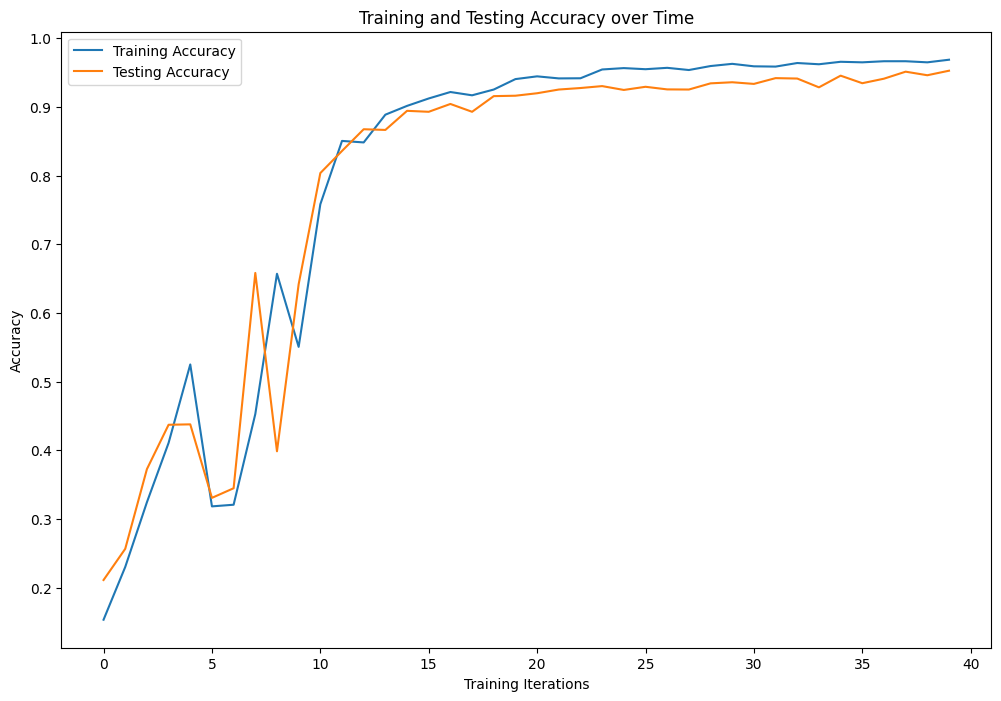

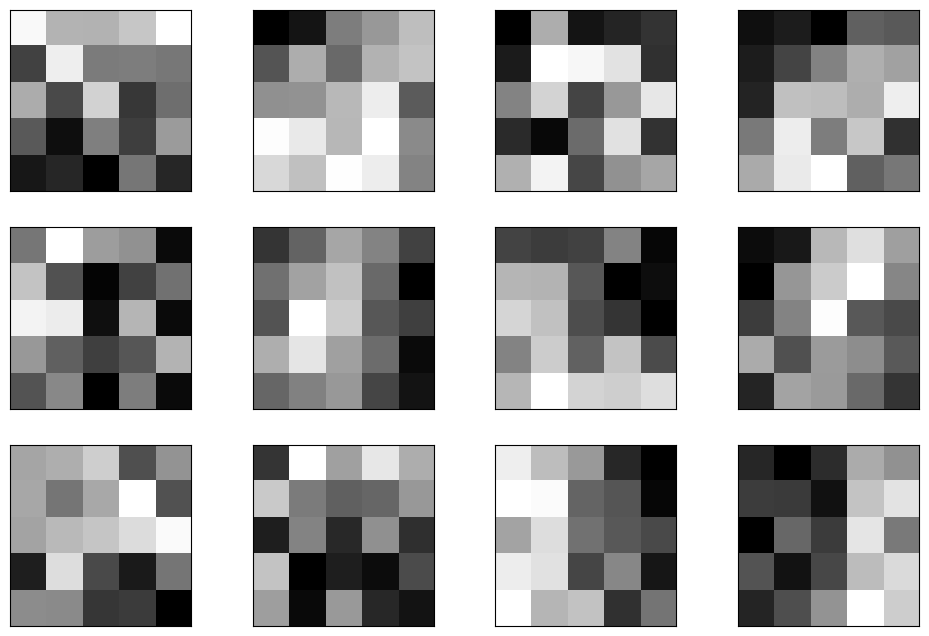

In [63]:
# Plot training and testing accuracy over time
plt.figure(figsize=(12, 8))
plt.plot(accuracy_train, label='Training Accuracy')
plt.plot(accuracy_test, label='Testing Accuracy')
plt.legend()
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Time')
plt.show()

# Plot the learned features in the first convolution layer
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

print(f"PART 3D), FINAL TESTING ACCURACY: {np.round(accuracy_test[-1] * 100, 2)}%")

- Does this perform better or worse than the previous models in this assignment?

🤔 Just comparing to the other models in this question, or from the whole assignment?

- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?

Convolutional layers are designed to capture spatial patterns, making them effective for tasks like image classification. However, the additional complexity of convolutional layers introduces more parameters and computations, which can increase training time and require larger datasets for effective training.

- Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

The V1 area of the brain is responsible for detecting features such as edges and lines. This is what is represented in the first convolution layer; smaller features which can then be inferred to understand shapes, in this case numbers.

**BONUS [1 mark]** Try to improve the neural network.  You want to get the best testing accuracy you can.  Try at least two different approaches and report your results.

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data with data augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

mnist = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)

# Define the network with convolution layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

# Create the network and optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.9)

# Variables to keep track of training and testing accuracy
accuracy_train = []
accuracy_test = []

# Training process with data augmentation
for i in range(100):
    network.train()
    correct_train = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        pred_train = output.data.max(1, keepdim=True)[1]
        correct_train += pred_train.eq(target.data.view_as(pred_train)).sum()
    
    # Calculate training accuracy and append to the list
    score_train = float(correct_train/len(train_loader.dataset))
    accuracy_train.append(score_train)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score_train)

    # Evaluate the model on the test set
    network.eval()
    correct_test = 0
    for data, target in test_loader:
        output = network(data)
        pred_test = output.data.max(1, keepdim=True)[1]
        correct_test += pred_test.eq(target.data.view_as(pred_test)).sum()

    # Calculate testing accuracy and append to the list
    score_test = float(correct_test/len(test_loader.dataset))
    accuracy_test.append(score_test)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score_test)

/var/folders/zz/c5vwdr1x3sd7k7qfw66pt9240000gn/T/ipykernel_60922/4031147863.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration 1 Training accuracy: 0.09740000218153
Iteration 1 Testing accuracy: 0.10859999805688858
Iteration 2 Training accuracy: 0.1550000011920929
Iteration 2 Testing accuracy: 0.24160000681877136
Iteration 3 Training accuracy: 0.34459999203681946
Iteration 3 Testing accuracy: 0.4410000145435333
Iteration 4 Training accuracy: 0.5583999752998352
Iteration 4 Testing accuracy: 0.6646000146865845
Iteration 5 Training accuracy: 0.48500001430511475
Iteration 5 Testing accuracy: 0.24040000140666962
Iteration 6 Training accuracy: 0.26980000734329224
Iteration 6 Testing accuracy: 0.3452000021934509
Iteration 7 Training accuracy: 0.4212000072002411
Iteration 7 Testing accuracy: 0.48739999532699585
Iteration 8 Training accuracy: 0.5601999759674072
Iteration 8 Testing accuracy: 0.6340000033378601
Iteration 9 Training accuracy: 0.5522000193595886
Iteration 9 Testing accuracy: 0.5120000243186951
Iteration 10 Training accuracy: 0.44519999623298645
Iteration 10 Testing accuracy: 0.37439998984336853
I

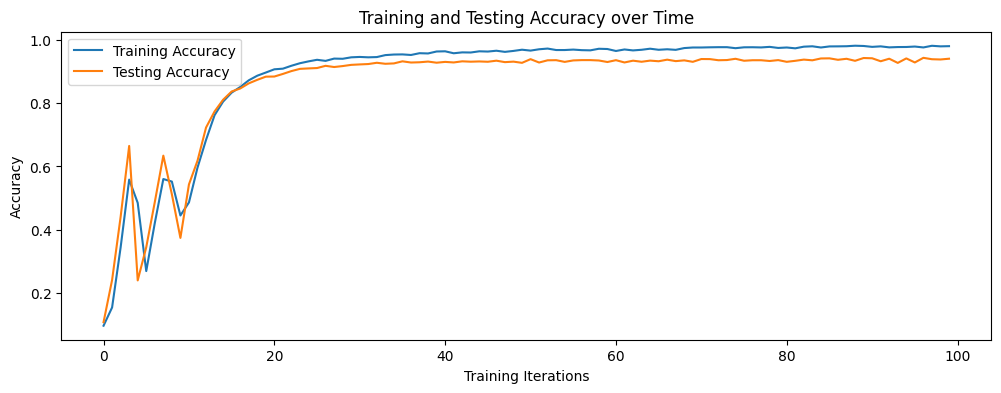

In [75]:
# Plot training and testing accuracy over time
plt.figure(figsize=(12, 4))
plt.plot(accuracy_train, label='Training Accuracy')
plt.plot(accuracy_test, label='Testing Accuracy')
plt.legend()
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Time')
plt.show()

print(f"BONUS, FINAL TESTING ACCURACY: {np.round(accuracy_test[-1] * 100, 2)}%")

To improve the neural network, I started from the convolution layer foundation of 3d and tried two different approaches:
1. Adding data augmentation (rotation)
2. Decreasing the learning rate to 0.01 and increasing the number of training epochs

This resulted in a final testing accuracy of.